In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# sns.set()

import os

import warnings
warnings.filterwarnings('ignore')

In [2]:
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import SelectPercentile, f_classif, f_regression, SelectFromModel, RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Input, concatenate, Embedding, Dot
from tensorflow.keras.layers import Activation, ReLU, LeakyReLU, PReLU
from tensorflow.keras.layers import BatchNormalization, Dropout, AlphaDropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model

from functools import partial

# Data load

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Column 설정

In [6]:
target = 'target'

In [7]:
columns_useless = ['id']
columns_useless = columns_useless + ['nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9', 'ord_5']

In [8]:
columns_num_all = joblib.load('columns_num.pkl')
columns_cat_all = joblib.load('columns_cat.pkl')
columns_binary_num = joblib.load('columns_binary_num.pkl')
columns_binary_cat = joblib.load('columns_binary_cat.pkl')

In [9]:
try :
    columns_num_all.remove(target)
    
except :
    pass

In [10]:
try :
    columns_cat_all.remove(target)
    
except :
    pass

In [11]:
columns_num = []

for column in columns_num_all :
    
    if column not in columns_useless :
        columns_num.append(column)

In [12]:
columns_cat = []

for column in columns_cat_all :
    
    if column not in columns_useless :
        columns_cat.append(column)

In [13]:
columns_sc = []

for column in columns_num :
    
    if column not in columns_binary_num:
        columns_sc.append(column)
        
columns_sc

[]

In [14]:
columns_en = []

for column in columns_cat :
    
    if (column not in columns_binary_num) and (column not in columns_binary_cat):
        columns_en.append(column)
        
columns_en

['nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_0',
 'day',
 'month']

# Data 분리

## target 분리

In [15]:
# y = data[target]
# X = data.drop(target, axis=1)

In [16]:
y_train = train[target]
X_train = train.drop(target, axis=1)
X_train_og = X_train.copy()

In [17]:
X_test = test.copy()

## Train & test set 분리

In [18]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=30)
# X_train_og = X_train.copy()

# Data preprocessing

In [19]:
def preprocessing(data, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en) :
    
    # useless column 제거
    data.drop(columns_useless, axis=1, inplace=True)
    
    # scaling
#     scaler = StandardScaler()
#     scaler.fit(X_train_og[columns_sc])
#     data[columns_sc] = scaler.transform(data[columns_sc])

    # binary data 처리
    column = columns_binary_cat[0]
    index_1 = data[data[column] == 'T'].index
    index_0 = data[data[column] == 'F'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    column = columns_binary_cat[1]
    index_1 = data[data[column] == 'Y'].index
    index_0 = data[data[column] == 'N'].index
    data.loc[index_1, column] = 1
    data.loc[index_0, column] = 0
    
    data[columns_binary_cat] = data[columns_binary_cat].astype('int64')
    
    # One-hot-encoding
    data = pd.get_dummies(data, columns=columns_en)
#     encoder = OneHotEncoder()
#     data = encoder.fit_transform(data)
    
    return data

In [20]:
X_train = preprocessing(X_train, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)
X_test = preprocessing(X_test, X_train_og, columns_useless, columns_sc, columns_binary_cat, columns_en)

In [21]:
if X_train.shape[1] != X_test.shape[1] :
    raise ValueError
    
else :
    print(X_train.shape)
    print(X_test.shape)

(300000, 104)
(200000, 104)


# ML model cross validation

In [22]:
knn = KNeighborsClassifier(n_neighbors=5)
logit = LogisticRegression(C=1.0, random_state=30)
sgd = SGDClassifier(max_iter=1000, eta0=0.0, random_state=30)
linsvm = LinearSVC(C=1.0, random_state=30)
svm = SVC(kernel='rbf', C=1.0, gamma='scale', random_state=30)
dt = DecisionTreeClassifier(max_depth=None, random_state=30)
rf = RandomForestClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=30)
et = ExtraTreesClassifier(n_estimators=100, max_depth=None, n_jobs=-1, random_state=30)
gb = GradientBoostingClassifier(learning_rate=0.1, n_estimators=1000, max_depth=3, random_state=30)
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3, random_state=30)
# lgb = LGBMClassifier(random_state=30)
adb = AdaBoostClassifier(random_state=30)
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='adam', alpha=0.0001, max_iter=200,
                    learning_rate='constant', learning_rate_init=0.001,random_state=30)

In [23]:
models = {
#     'knn' : knn,
    'logit' : logit,
    'sgd' : sgd,
    'linsvm' : linsvm,
#     'svm' : svm,
    'dt' : dt,
    'rf' : rf,
    'et' : et,
    'gb' : gb,
#     'xgb' : xgb,
#     'lgb' : lgb,
    'adb' : adb,
#     'mlp' : mlp
}

In [24]:
# result = []

# for key, model in models.items() : 
#     score = cross_validate(model, X_train, y_train, cv=5, scoring='roc_auc', return_train_score=True, n_jobs=-1)  
#     score = pd.DataFrame(score).mean()
    
#     result.append(score)

logit : 0.743
sgd : 0.738
linsvm : 0.743
dt : 0.564
rf : 0.711
et : 0.707
gb : 0.74
adb : 0.734
mlp : 0.713


- logit : 0.743
- sgd : 0.738
- linsvm : 0.743
- dt : 0.564
- rf : 0.711
- et : 0.707
- gb : 0.74
- adb : 0.734
- mlp : 0.713

In [ ]:
# result = pd.concat(result, axis=1)
# result.columns = models.keys()
# result = result.T
# result = result[['test_score', 'train_score', 'fit_time', 'score_time']]
# result = round(result, 3)
# result

## Validation set 분리 검증
- Train dataset이 너무 커서 cross validation에 너무 오랜 시간이 걸리는 경우

In [25]:
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=30)

In [26]:
# for key, model in models.items() :
#     model.fit(X_train, y_train)
#     print(key, ':', model.score(X_val, y_val))

# Nerual network

In [27]:
def plot_result(history) :
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], 'b--', label='loss')
    plt.plot(history.history['val_loss'], 'r-', label='val_loss')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['auc'], 'b--', label='auc')
    plt.plot(history.history['val_auc'], 'r-', label='val_auc')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.legend()

In [28]:
np.random.seed(30)
tf.random.set_seed(30)

In [29]:
model = Sequential()
model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal', input_shape=(X_train.shape[1],)))

for layer in range(5):
    model.add(Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    
model.add(Dense(2, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               10500     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_5 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 2

In [30]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

In [31]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)   # metrics로 'AUC'를 사용하기 위해 one-hot-encoding 사용

In [32]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])

In [33]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20, restore_best_weights=True)

In [34]:
history = model.fit(X_train, y_train, epochs=100, validation_split=0.25, callbacks=early_stopping_cb)

Epoch 1/100
7032/7032 [==============================] - 13s 2ms/step - loss: 0.5403 - auc: 0.8023 - val_loss: 0.5369 - val_auc: 0.8054
Epoch 2/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5353 - auc: 0.8066 - val_loss: 0.5366 - val_auc: 0.8062
Epoch 3/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5332 - auc: 0.8084 - val_loss: 0.5383 - val_auc: 0.8054
Epoch 4/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5311 - auc: 0.8101 - val_loss: 0.5383 - val_auc: 0.8046
Epoch 5/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5290 - auc: 0.8120 - val_loss: 0.5403 - val_auc: 0.8037
Epoch 6/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5263 - auc: 0.8142 - val_loss: 0.5412 - val_auc: 0.8019
Epoch 7/100
7032/7032 [==============================] - 12s 2ms/step - loss: 0.5239 - auc: 0.8162 - val_loss: 0.5448 - val_auc: 0.7991
Epoch 8/100
7032/7032 [=========================

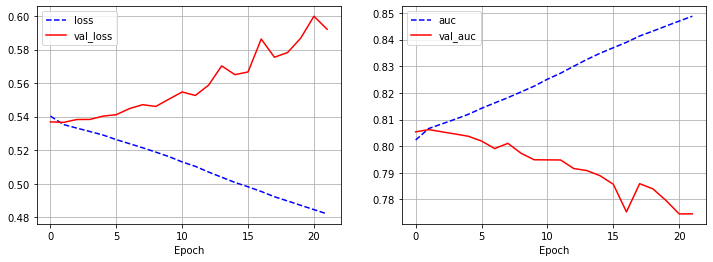

In [35]:
plot_result(history)

- loss: 0.4820
- auc: 0.8488
- val_loss: 0.5921
- val_auc: 0.7746